In [2]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

import numpy as np
import os, glob, atexit, signal
os.nice(19)
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

In [3]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gal1s = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gal2s = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

from common_func import *

In [4]:
if(not os.path.exists(f"{database1}/LocalGroup.pickle")):
    LG1 = pklload(f"{database1}/LG.pickle")
    keys = list(LG1.keys())
    for key in keys:
        if(not LG1[key]['isLG']):
            del LG1[key]
    pklsave(LG1, f"{database1}/LocalGroup.pickle")
LG1 = pklload(f"{database1}/LocalGroup.pickle")

if(not os.path.exists(f"{database2}/LocalGroup.pickle")):
    LG2 = pklload(f"{database2}/LG.pickle")
    keys = list(LG2.keys())
    for key in keys:
        if(not LG2[key]['isLG']):
            del LG2[key]
    pklsave(LG2, f"{database2}/LocalGroup.pickle")
LG2 = pklload(f"{database2}/LocalGroup.pickle")

In [111]:
allsubs1 = None
states1 = None
for key in LG1.keys():
    subs = LG1[key]['subs']
    real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]
states1 = states1[argsort]

In [110]:
allsubs2 = None
states2 = None
for key in LG2.keys():
    subs = LG2[key]['subs']
    real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]
states2 = states2[argsort]

In [114]:
allsubs1['id'], allsubs1.shape

(array([  693,  1309,  1310, ..., 28532, 28581, 28582], dtype=int32), (1336,))

In [115]:
allsubs2['id'], allsubs2.shape

(array([  644,  1529,  1577, ..., 28895, 28896, 28899], dtype=int32), (1242,))

In [116]:
tree2 = pklload(f"{database2}/main_progenitors.pickle")
tree2.shape, tree2.dtype, tree2[0]

((972486,),
 dtype([('lastid', '<i2'), ('timestep', '<i2'), ('id', '<i2'), ('give_score', '<f8'), ('take_score', '<f8')]),
 (644, 797, 644, 1., 1.))

In [117]:
fnames2 = os.listdir(f"{database2}/main_prog")
fnames2 = [fname for fname in fnames2 if(fname.startswith('subhalos'))]
fnames2.sort(reverse=True)

tmp = pklload(f"{database2}/main_prog/{fnames2[0]}")[0]
trees2 = np.empty(tmp.shape[0]*len(fnames2), dtype=tmp.dtype)
cursor = 0
uri.timer.verbose=0
for fname in tqdm( fnames2 ):
    tmp = pklload(f"{database2}/main_prog/{fname}")[0]
    trees2[cursor : cursor+len(tmp)] = tmp
    cursor += len(tmp)
trees2 = trees2[trees2['timestep'] <= iout2]
trees2.shape

  0%|          | 0/797 [00:00<?, ?it/s]

(973728,)

ValueError: 

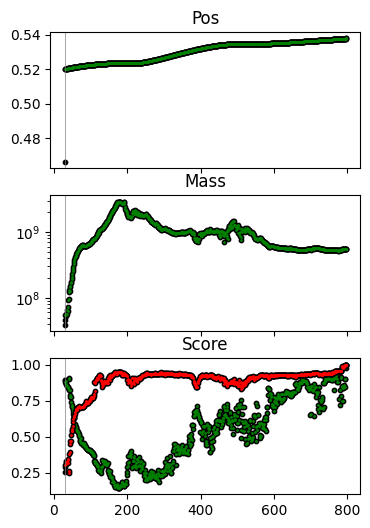

In [181]:
reduced_tree2 = {}
for i, sub in tqdm(enumerate(allsubs2), total=len(allsubs2)):
    arg = np.where(allsubs2['id']==sub['id'])[0][0]
    branch = trees2[arg::len(allsubs2)]#[trees['lastid'] == target['id']]
    branch = branch[branch['take_score']>0]

    score = branch['give_score']*branch['take_score']/branch['aexp']*snap2['aexp']
    umask = (score > 0.1) & (branch['take_score']>0.1)# | ((branch['give_score']+branch['take_score']) > 1.1) | (branch['take_score'] > 0.4)

    dx = np.abs(np.diff(branch['x']))
    meandx = np.mean(dx)
    dy = np.abs(np.diff(branch['y']))
    meandy = np.mean(dy)
    dz = np.abs(np.diff(branch['z']))
    meandz = np.mean(dz)
    dp = np.sqrt(dx**2 + dy**2 + dz**2)
    meandp = np.sqrt(meandx**2 + meandy**2 + meandz**2)
    pmask = dp <= meandp
    pmask = np.insert(pmask, 0, True)

    first = np.min(branch['timestep'][umask & pmask])

    cbranch = branch[branch['timestep'] >= first]
    top20per = top20per = np.argsort(branch['take_score'])[-int(len(branch)/5):]
    if(len(top20per)>10):
        m16,m50,m84 = np.percentile(branch['mdm_vir'][top20per], q=[16,50,84])
        lower = m16/10; upper = m84*10
        if(lower > branch[0]['mdm_vir']): lower = branch[0]['mdm_vir']
        if(upper < branch[0]['mdm_vir']): upper = branch[0]['mdm_vir']
    else:
        lower = branch[0]['mdm_vir']/10; upper = branch[0]['mdm_vir']*10

    mbranch = cbranch[(cbranch['mdm_vir'] <= upper)&(cbranch['mdm_vir'] >= lower)&(cbranch['take_score']>0.01)]
    reduced_tree2[sub['id']] = mbranch
pklsave(reduced_tree2,f"{database2}/reduced_tree.pickle", overwrite=True)
val = 'z'

nprop=3
fig, axes = plt.subplots(nprop,1, sharex=True, figsize=(4,2*nprop))
axes[0].set_title("Pos")
axes[0].scatter(branch['timestep'], branch[val], color='k', s=10)
axes[0].scatter(mbranch['timestep'], mbranch[val], color='g', s=1)
axes[0].axvline(first, color='grey', lw=0.5)
axes[1].set_title("Mass")
axes[1].scatter(branch['timestep'], branch['mdm_vir'], color='k', s=10)
axes[1].scatter(mbranch['timestep'], mbranch['mdm_vir'], color='g', s=1)
axes[1].set_yscale('log')
axes[1].axvline(first, color='grey', lw=0.5)
axes[2].set_title("Score")
axes[2].scatter(branch['timestep'], branch['take_score'], color='k', s=10)
axes[2].scatter(mbranch['timestep'], mbranch['take_score'], color='g', s=1)
axes[2].scatter(branch['timestep'], branch['give_score'], color='k', s=10)
axes[2].scatter(mbranch['timestep'], mbranch['give_score'], color='r', s=1)
axes[2].axvline(first, color='grey', lw=0.5)

raise ValueError("")

In [157]:
meandx

-1.0029314506294638e-05

In [158]:
dx

array([ 2.94426053e-05,  3.07375533e-05,  5.75731948e-05,  1.29250051e-05,
        3.13253677e-05, -1.53631706e-05,  7.82228404e-05,  1.23667157e-06,
        3.20250529e-05,  3.12562670e-05,  3.26445228e-05,  1.28519644e-06,
       -3.75998323e-05,  9.79534958e-05, -3.76482989e-05,  1.76631341e-05,
        1.14406324e-05,  1.01399887e-04,  3.28748648e-05, -5.06860752e-05,
        3.21078820e-06,  2.32083743e-05,  3.03396260e-05,  2.71293187e-05,
        2.51922033e-05,  1.02938835e-05,  1.78213702e-05,  2.69669784e-05,
        2.89149099e-05,  2.88202688e-05,  1.04980911e-06,  2.46433619e-05,
        2.59601197e-05,  2.70404950e-05,  1.23583214e-05,  1.39711176e-05,
        3.52012925e-05,  2.62147775e-05,  2.06551456e-05,  7.95471244e-06,
        2.48665092e-05,  2.47177787e-05,  2.60488541e-05,  4.44341169e-06,
        2.00206257e-05,  3.12071104e-05,  2.55673719e-05,  6.42277670e-06,
        2.07504842e-05,  2.59343695e-05,  2.83086472e-05,  1.83788308e-05,
        7.05875253e-06,  

In [156]:
dp

array([3.68109300e-05, 3.81143386e-05, 7.67052989e-05, 1.67174064e-05,
       3.86258131e-05, 8.14346743e-05, 8.57610771e-05, 1.55142371e-06,
       4.03629674e-05, 3.90348423e-05, 3.96882897e-05, 1.61771962e-06,
       7.87583505e-05, 1.00407932e-04, 8.24141173e-05, 1.98915524e-05,
       1.45906994e-05, 1.02737143e-04, 4.06881458e-05, 8.03939440e-05,
       4.21485527e-06, 3.01139547e-05, 3.81887719e-05, 3.43267026e-05,
       3.43090223e-05, 1.43537391e-05, 2.23283319e-05, 3.51286579e-05,
       3.86851265e-05, 3.49326760e-05, 1.35658430e-06, 3.45593468e-05,
       3.69729384e-05, 3.65807430e-05, 1.27857425e-05, 2.14593918e-05,
       4.18164790e-05, 3.73079606e-05, 2.54558469e-05, 1.05160740e-05,
       3.48549066e-05, 3.21834360e-05, 3.51130205e-05, 6.72737387e-06,
       2.45447029e-05, 3.86885573e-05, 3.64524553e-05, 1.25508232e-05,
       2.73603274e-05, 3.11376341e-05, 3.89564405e-05, 2.54881410e-05,
       9.77464478e-06, 3.53935908e-05, 3.39342227e-05, 2.86659189e-05,
      

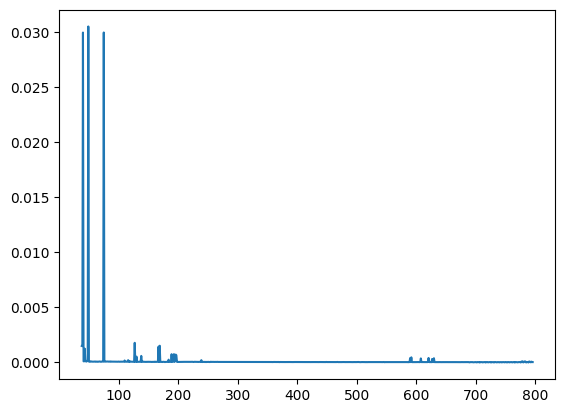

In [153]:
plt.plot(branch['timestep'][1:], dp-meandp)

ValueError: 

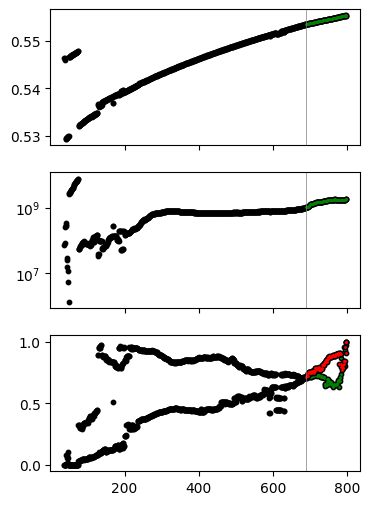

In [149]:
nprop=3
fig, axes = plt.subplots(nprop,1, sharex=True, figsize=(4,2*nprop))
axes[0].scatter(branch['timestep'], branch[val], color='k', s=10)
axes[0].scatter(mbranch['timestep'], mbranch[val], color='g', s=1)
axes[0].axvline(first, color='grey', lw=0.5)
axes[1].scatter(branch['timestep'], branch['mdm_vir'], color='k', s=10)
axes[1].scatter(mbranch['timestep'], mbranch['mdm_vir'], color='g', s=1)
axes[1].set_yscale('log')
axes[1].axvline(first, color='grey', lw=0.5)
axes[2].scatter(branch['timestep'], branch['take_score'], color='k', s=10)
axes[2].scatter(mbranch['timestep'], mbranch['take_score'], color='g', s=1)
axes[2].scatter(branch['timestep'], branch['give_score'], color='k', s=10)
axes[2].scatter(mbranch['timestep'], mbranch['give_score'], color='r', s=1)
axes[2].axvline(first, color='grey', lw=0.5)

raise ValueError("")

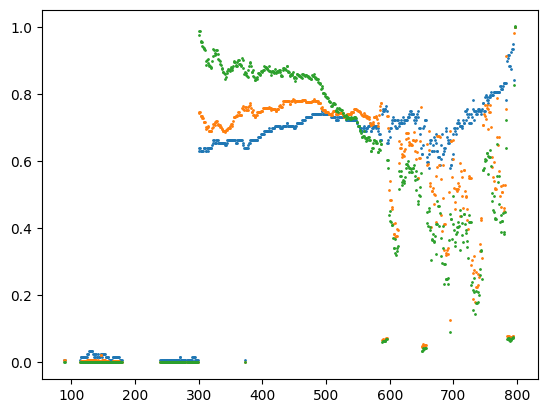

In [104]:
plt.scatter(branch['timestep'], branch['give_score'], s=1)
plt.scatter(branch['timestep'], branch['take_score'], s=1)
plt.scatter(branch['timestep'], score, s=1)

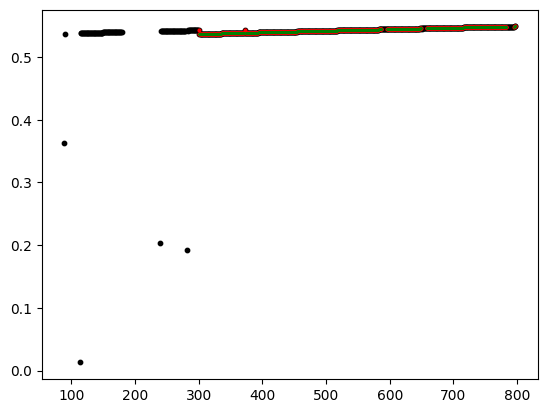

In [105]:
val = 'z'
plt.scatter(branch['timestep'], branch[val], color='k', s=10)
plt.scatter(branch[umask]['timestep'], branch[umask][val], color='r', s=4)
# plt.axhline(np.median(branch[umask][val]), color='grey', linestyle='--', lw=0.5)
plt.scatter(branch[umask&pmask]['timestep'], branch[umask&pmask][val], color='g', s=1)

22651 774 upair
0.19291338582677164 0.04096100827097282


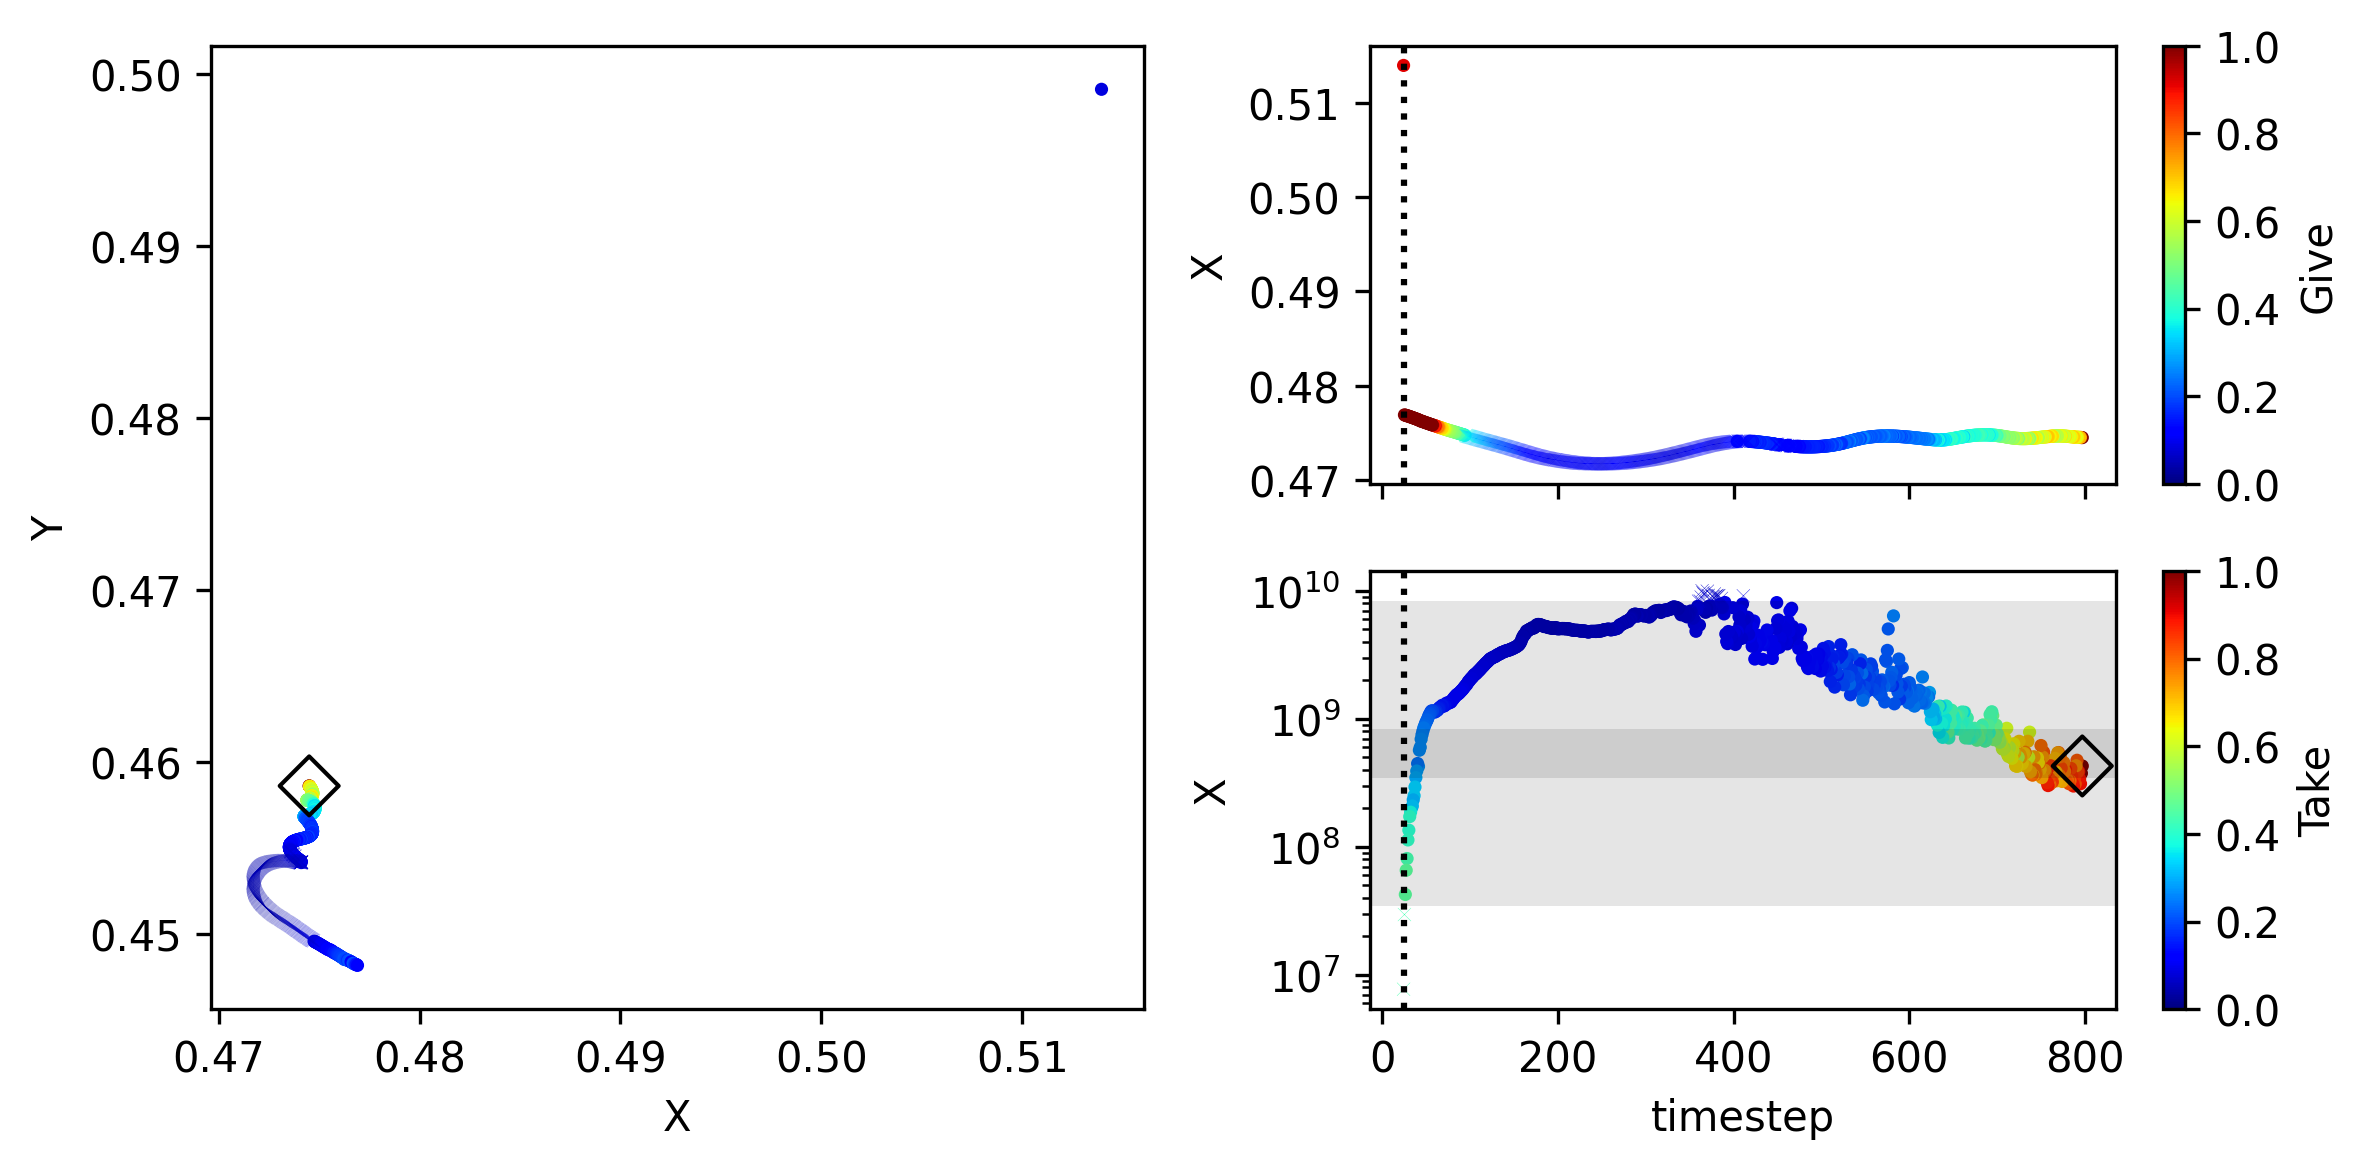

In [44]:
where = np.arange(len(allsubs))
length=10000
while(length>500):
    state='dink'
    while(state=='dink'):
        random = np.random.choice(where)
        target = allsubs[random]
        state = states[random]
    # print(states[where])

    branch = trees[trees['lastid'] == target['id']]
    branch = branch[branch['take_score']>0]
    score = branch['give_score']*branch['take_score']/branch['aexp']*snap2['aexp']
    umask = (score > 0.1) & (branch['take_score']>0.1) & (branch['give_score']>0.1)# | ((branch['give_score']+branch['take_score']) > 1.1) | (branch['take_score'] > 0.4)
    length = np.sum(umask)

val = 'mdm_vir'
# log = False
log = True
top20per = np.argsort(branch['take_score'])[-int(len(branch)/5):]
m16,m50,m84 = np.percentile(branch['mdm_vir'][top20per], q=[16,50,84])
if(log):
    lower = m16/10; upper = m84*10
else:
    lower = m16 - (m50-m16); upper = m84 + (m84+50)
if(lower > branch[0]['mdm_vir']): lower = branch[0]['mdm_vir']
if(upper < branch[0]['mdm_vir']): upper = branch[0]['mdm_vir']

mmask = (branch[val] < upper)&(branch[val] > lower)
print(target['id'],len(branch), state)

fig = plt.figure(tight_layout=True, dpi=300, figsize=(8,4))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[:, 0])

print(np.min(branch['give_score']), np.min(branch['take_score']))
first = np.min(branch[umask]['timestep'])
tmask = branch['timestep'] >= (first)
score = branch['give_score']*branch['take_score']
sc = ax.scatter(branch[umask & tmask]['x'], branch[umask & tmask]['y'], c=score[umask & tmask], ec='none', cmap=plt.cm.jet, vmin=0, vmax=1, s=10)
ax.scatter(branch[~umask & tmask]['x'], branch[~umask & tmask]['y'], c=score[~umask & tmask], marker='x', cmap=plt.cm.jet, vmin=0, vmax=1, s=10, lw=0.1, alpha=0.5)
ax.scatter(branch[0]['x'], branch[0]['y'], fc='none', ec='k', marker='D', s=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax = fig.add_subplot(gs[0, 1])
ax.set_xticklabels([])
score = branch['give_score']*branch['take_score']/branch['aexp']*snap2['aexp']
# mask = score > 0.2
sc = ax.scatter(branch[umask]['timestep'], branch[umask]['x'], c=score[umask], ec='none', cmap=plt.cm.jet, vmin=0, vmax=1, s=10)
ax.scatter(branch[~umask]['timestep'], branch[~umask]['x'], c=score[~umask], marker='x', cmap=plt.cm.jet, vmin=0, vmax=1, s=10, lw=0.1)
ax.set_ylabel("X")
ax.axvline(first, c='k',ls=':')
fig.colorbar(sc, ax=ax, label='Give')

ax = fig.add_subplot(gs[1, 1])#, sharex=ax)
score = branch['take_score']#*branch['take_score']
# mask = score > 0.1

# mmask2 = remove_peak(branch)
# for it in branch[~mmask2]['timestep']:
#     ax.axvline(it, color='k', lw=0.2)
mmask = mmask & tmask

sc = ax.scatter(branch[mmask]['timestep'], branch[mmask][val], c=score[mmask], ec='none', cmap=plt.cm.jet, vmin=0, vmax=1, s=10)
ax.scatter(branch[~mmask]['timestep'], branch[~mmask][val], c=score[~mmask], marker='x', cmap=plt.cm.jet, vmin=0, vmax=1, s=10, lw=0.1)
ax.scatter(branch[0]['timestep'], branch[0][val], fc='none', ec='k', marker='D', s=100)
ax.axhspan(m16, m84, fc='k', alpha=0.1, ec='none')
ax.axhspan(lower, upper, fc='k', alpha=0.1, ec='none')
ax.set_xlabel("timestep")
ax.set_ylabel("X")
if(log): ax.set_yscale('log')
ax.axvline(first, c='k',ls=':')
fig.colorbar(sc, ax=ax, label='Take')


plt.subplots_adjust(hspace=0)

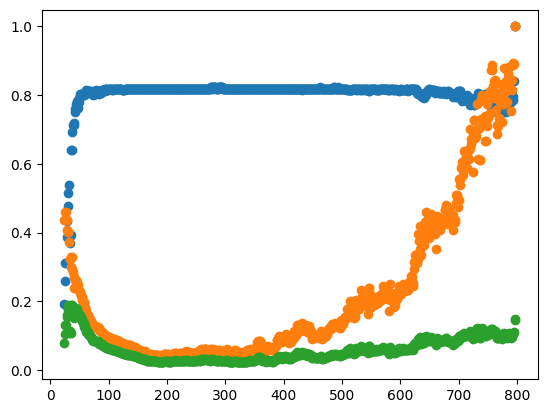

In [46]:
plt.scatter(branch['timestep'], branch['give_score'])
plt.scatter(branch['timestep'], branch['take_score'])
plt.scatter(branch['timestep'], branch['give_score']*branch['take_score']*(1-branch['aexp']))

In [37]:
ptree_dm = pklload(f"/storage8/NH2/ptree_dm/ptree_stable.pkl")

In [38]:
tmp = ptree_dm[ptree_dm['timestep'] == iout2]
tmp = tmp[tmp['hmid'] == target['id']][0]
tmp

(540, 797, 3, 5752, 25351, 0, 25457, 0.85355043, 7.0481358e+08, 0.48770093, 0.53484451, 0.52252727, -280.31604115, -63.29502156, 109.79088067, 5919727.83060436, 9245933.36796593, -128441.25144857, 0.00014597, 0.0063073, 0.00333447, 0.00240918, 65.65478109, -1.76682238, 63.88795871, 0.48925191, 88.47632292, 0.00010335, 7.0481358e+08, 8684.72156774, 15.5535925, 285.04770528, 0.00010335, [[467,  73,   0,   0], [354, 186,   0,   0], [314, 226,   0,   0]], 25456, 344648587, [[345384104, 342682311,        -1,        -1], [344753611, 341845078,        -1,        -1], [344071227, 341034985,        -1,        -1]], 344884919, 345384104, 0.25894224, 0.32361259, 1, 1, 344884932, 345200142, -1, -1)

In [40]:
pbranch = ptree_dm[ptree_dm['last'] == tmp['last']]

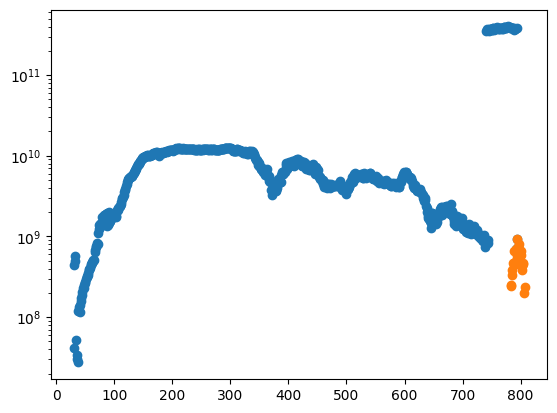

In [42]:
plt.scatter(branch['timestep'], branch['mvir'])
plt.scatter(pbranch['timestep'], pbranch['mvir'])
plt.yscale('log')

In [39]:
tmp.dtype

dtype([('nparts', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('npass', '<i4', (3, 4)), ('hmid', '<i4'), ('id', '<i8'), ('desc', '<i8', (3, 4)), ('fat', '<i8'), ('son', '<i8'), ('score_fat', '<f8'), ('score_son', '<f8'), ('nprog', '<i8'), ('ndesc', '<i8'), ('first', '<i8'), ('last', '<i8'), ('first_rev', '<i8'), ('last_rev', '<i8')])

In [14]:
branch.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

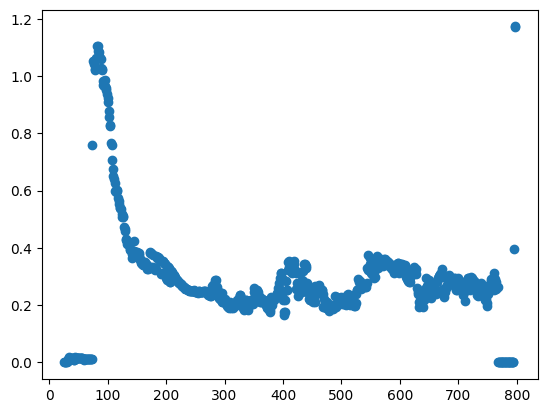

In [35]:
plt.scatter(branch['timestep'], branch['take_score']*branch['give_score']/branch['aexp'])
# plt.yscale('log')

In [30]:
def remove_peak(branch):
    leng = len(branch)
    bools = np.zeros(leng, dtype=bool); bools[:] = True#; bools[0] = True; bools[-1] = True
    for i in range(leng-2):
        cursor = branch[i+1]
        befo = branch[i]
        afte = branch[i+2]

        diff = np.abs(np.log10(befo['mvir']) - np.log10(afte['mvir']))+1
        diffb = np.abs(np.log10(befo['mvir']) - np.log10(cursor['mvir']))
        diffa = np.abs(np.log10(cursor['mvir']) - np.log10(afte['mvir']))
        if(diffb > diff)or(diffa > diff):
            print(i, diffb, diffa, diff)
            bools[i+1] = False
    return bools


773


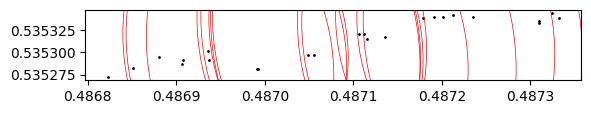

In [18]:
def fix_tree(branch):
    # last snapshot should be located at the first
    leng = len(branch)
    bools = np.zeros(leng, dtype=bool); bools[:] = False; bools[0] = True
    current = branch[0]
    dists = np.zeros(leng)
    offset = 1
    for i in range(leng-1):
        prev = branch[i+1]
        # offset = current['timestep'] - prev['timestep']
        dist = distance(current, prev)
        ok1 = dist <= (2*np.max(dists)*offset)
        # print(dist, np.max(dists), offset)
        mscore = np.abs(np.log10(prev['mvir']/current['mvir'])) + 1
        tscore = prev['take_score']*prev['give_score']/prev['aexp']*snap2['aexp']
        # print(prev['timestep'], tscore, mscore)
        ok2 = (tscore/mscore) > 0.5
        # ok2 = np.abs(np.log10(prev['mvir']/current['mvir'])) <= 0.5
        # ok3 = prev['take_score'] > 0.1
        # ok4 = prev['give_score'] > 0.1

        # ok = ok1 & ok2# & ok3 & ok4
        if(ok1): ok=True
        elif(ok2): ok=True
        else: ok=False
        if(ok):
            bools[i+1] = True
            current = prev
            if(ok1): dists[i+1] = dist
            offset=1
        else:
            offset += 1
    return bools

bools = fix_tree(branch)
first = np.where(bools)[0][-1]
print(branch[bools][-1]['timestep'])
plt.scatter(branch[:first]['x'], branch[:first]['y'], c='k', s=1)
for ib in branch[bools]:
    cir = plt.Circle((ib['x'], ib['y']), ib['rvir'], fill=False, ec='r', lw=0.5)
    plt.gca().add_artist(cir)
plt.gca().set_aspect('equal')